# 1. Parameters

In [1]:
from pathlib import Path
from os import mkdir
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

cases_root_dir = Path('cases')

figures_path = Path('figures')
if not figures_path.exists():
    mkdir(figures_path)
    
samples_cases = [5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000]
cases_paths = [cases_root_dir / f'case-{x}' for x in samples_cases]

metadata_file = Path('input/metadata-subsample-pangolin.tsv')

In [2]:
import genomics_data_index

print(genomics_data_index.__version__)

0.4.0.dev1


# 2. Indexing

## 2.1. Samples comparison

In [3]:
from typing import List

index_info_paths = [x / 'index-info.tsv' for x in cases_paths]
index_info_paths = [x for x in index_info_paths if x.exists()]

def read_all_df(index_paths: List[Path]) -> pd.DataFrame:
    dfs = []
    for index in index_paths:
        dfs.append(pd.read_csv(index, sep='\t'))
        
    return pd.concat(dfs).reset_index(drop=True)

index_info_df = read_all_df(index_info_paths)
index_info_df['Samples'] = index_info_df['Name'].str.extract(r'^case-(\d+)').astype(int)
index_info_df['Number features (unknown)'] = index_info_df['Number features (all)'] - \
                                             index_info_df['Number features (no unknown)']
index_info_df[
    'Percent of reference genome with unknown/missing features'] = 100 * (index_info_df[
    'Number features (unknown)'] / index_info_df['Reference length'])
index_info_df.head(5)

,Name,Iteration,Number samples,Number features (all),Number features (no unknown),Number cores,Reference length,Analysis runtime,Analysis memory (max),Analysis memory (max/process),...,Index memory (max/process),Index size,Tree runtime,Tree memory (max),Tree memory (max/process),Total runtime,Max memory,Samples,Number features (unknown),Percent of reference genome with unknown/missing features
0,case-10,1,10,2900,44,32,29903,139.78,1.429692e+09,377692160.0,...,234856448.0,761856.0,92.58,249139200.0,219570176.0,237.23,5.391446e+09,10,2856,9.550881
1,case-10,2,10,2900,44,32,29903,138.50,1.448071e+09,368533504.0,...,235270144.0,757760.0,82.70,249458688.0,220327936.0,225.89,5.393736e+09,10,2856,9.550881
2,case-10,3,10,2900,44,32,29903,139.58,1.444766e+09,380194816.0,...,234606592.0,761856.0,82.05,248881152.0,219791360.0,226.14,5.389349e+09,10,2856,9.550881
3,case-20,1,20,11560,61,32,29903,137.43,1.815732e+09,366129152.0,...,271831040.0,1957888.0,114.02,241582080.0,220491776.0,258.05,5.498565e+09,20,11499,38.454336
4,case-20,2,20,11560,61,32,29903,156.56,1.670365e+09,371167232.0,...,267173888.0,1961984.0,118.27,240123904.0,220340224.0,281.66,5.496709e+09,20,11499,38.454336


### 2.1.1. Common styles 

In [4]:
stages_palette = ['#1b9e77', '#7570b3', '#d95f02', '#000000']
stages_markers = ['o', 's', '^', 'X']
stages_palette_nototal = ['#1b9e77', '#7570b3', '#d95f02']
stages_markers_nototal = ['o', 's', '^']
stages_palette_notree = ['#1b9e77', '#7570b3', '#000000']
stages_markers_notree = ['o', 's', 'X']

### 2.1.2. Runtime plots

In [5]:
from typing import Callable

def melt_runtimes(df: pd.DataFrame, include_tree_na: bool, id_vars: str) -> pd.DataFrame:
    df = df.copy()
    if include_tree_na:
        df = df[~df['Tree runtime'].isna()]
        value_vars = ['Analysis runtime', 'Index runtime', 'Tree runtime', 'Total runtime']
    else:
        df['Total runtime'] = df['Analysis runtime'] + df['Index runtime']
        value_vars = ['Analysis runtime', 'Index runtime', 'Total runtime']
    df = pd.melt(df, id_vars=id_vars,
            value_vars=value_vars)
    df = df.rename({'variable': 'Stage', 'value': 'Time (seconds)'}, axis='columns')
    df['Stage'] = df['Stage'].str.replace(' runtime', '', regex=False)
    df['Time (minutes)'] = df['Time (seconds)'] / 60
    df['Time (hours)'] = df['Time (seconds)'] / 3600
    return df

def melt_and_combine_with_without_tree(df: pd.DataFrame, melt_func: Callable[[pd.DataFrame, bool, str], pd.DataFrame],
                                      id_vars: str) -> pd.DataFrame:
    tree_df = melt_func(df, include_tree_na=True, id_vars=id_vars)
    tree_df['Type'] = 'Include Tree'
    ntree_df = melt_func(df, include_tree_na=False, id_vars=id_vars)
    ntree_df['Type'] = 'Exclude Tree'
    
    return pd.concat([tree_df, ntree_df])

In [6]:
index_info_runtime_df = melt_and_combine_with_without_tree(index_info_df,
                                                           melt_func=melt_runtimes,
                                                           id_vars='Samples')
index_info_runtime_df

,Samples,Stage,Time (seconds),Time (minutes),Time (hours),Type
0,10,Analysis,139.78,2.329667,0.038828,Include Tree
1,10,Analysis,138.50,2.308333,0.038472,Include Tree
2,10,Analysis,139.58,2.326333,0.038772,Include Tree
3,20,Analysis,137.43,2.290500,0.038175,Include Tree
4,20,Analysis,156.56,2.609333,0.043489,Include Tree
...,...,...,...,...,...,...
94,10000,Total,4468.69,74.478167,1.241303,Exclude Tree
95,10000,Total,4534.87,75.581167,1.259686,Exclude Tree
96,20000,Total,9064.83,151.080500,2.518008,Exclude Tree
97,20000,Total,9265.24,154.420667,2.573678,Exclude Tree


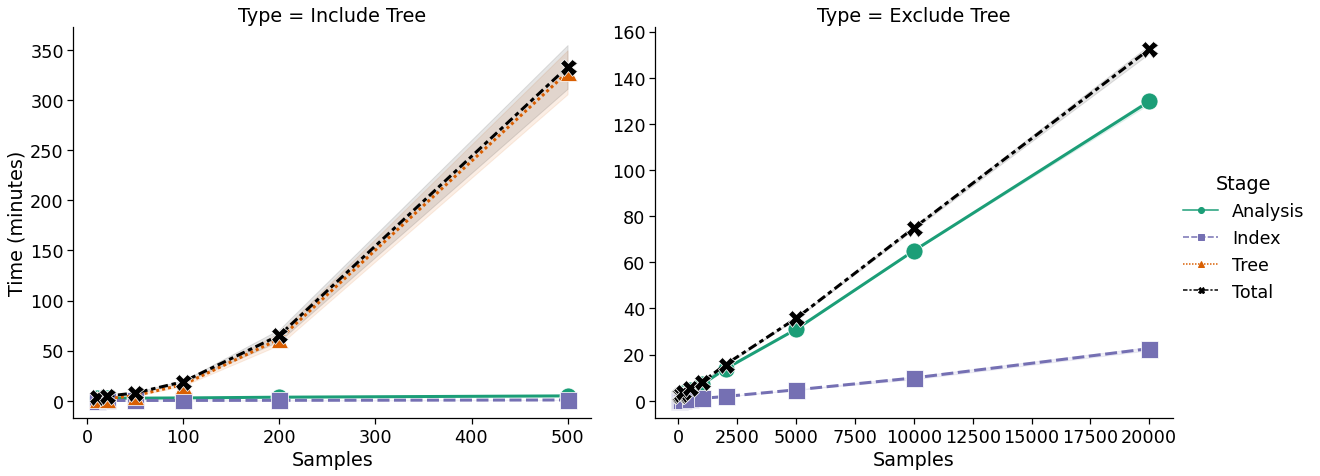

In [7]:
with sns.plotting_context("notebook", font_scale=1.6):
    g = sns.relplot(x='Samples', y='Time (minutes)', hue="Stage", style="Stage", ci="sd", kind="line",
                    data=index_info_runtime_df, col="Type", markers=stages_markers, estimator='mean',
                    height=7, aspect=1.2, linewidth=3, markersize=17, err_kws={"alpha": 0.1},
                    palette=stages_palette,
                    facet_kws={'sharey': False, 'sharex': False})
    plt.savefig('figures/index-runtime.pdf')

#### 2.1.2.1. Mean/stdevs

In [8]:
index_info_runtime_df.groupby(['Samples', 'Stage', 'Type']).agg(['mean', 'std', 'count'])

Time (seconds)                     \
                                        mean          std count   
Samples Stage    Type                                             
10      Analysis Exclude Tree     139.286667     0.688573     3   
                 Include Tree     139.286667     0.688573     3   
        Index    Exclude Tree       4.690000     0.180000     3   
                 Include Tree       4.690000     0.180000     3   
        Total    Exclude Tree     143.976667     0.736569     3   
                 Include Tree     229.753333     6.476190     3   
        Tree     Include Tree      85.776667     5.900816     3   
20      Analysis Exclude Tree     144.226667    10.699544     3   
                 Include Tree     144.226667    10.699544     3   
        Index    Exclude Tree       6.780000     0.160935     3   
                 Include Tree       6.780000     0.160935     3   
        Total    Exclude Tree     151.006667    10.752973     3   
                 Include Tree     264.466667    15.048602     3   
        Tree     Include Tree     113.460000     5.113052     3   
50      Analysis Exclude Tree     146.906667     1.275631     3   
                 Include Tree     146.906667     1.275631     3   
        Index    Exclude Tree       8.556667     0.124231     3   
                 Include Tree       8.556667     0.124231     3   
        Total    Exclude Tree     155.463333     1.326135     3   
                 Include Tree     457.786667    48.658527     3   
        Tree     Include Tree     302.323333    49.376159     3   
100     Analysis Exclude Tree     160.723333     1.011056     3   
                 Include Tree     160.723333     1.011056     3   
        Index    Exclude Tree      11.083333     0.189297     3   
                 Include Tree      11.083333     0.189297     3   
        Total    Exclude Tree     171.806667     0.941134     3   
                 Include Tree    1136.500000    71.928017     3   
        Tree     Include Tree     964.693333    72.853042     3   
200     Analysis Exclude Tree     205.080000     2.601442     3   
                 Include Tree     205.080000     2.601442     3   
        Index    Exclude Tree      16.206667     0.591636     3   
                 Include Tree      16.206667     0.591636     3   
        Total    Exclude Tree     221.286667     3.157219     3   
                 Include Tree    3916.993333   354.519364     3   
        Tree     Include Tree    3695.706667   357.311934     3   
500     Analysis Exclude Tree     282.696667     6.515476     3   
                 Include Tree     282.696667     6.515476     3   
        Index    Exclude Tree      36.900000     0.147986     3   
                 Include Tree      36.900000     0.147986     3   
        Total    Exclude Tree     319.596667     6.423584     3   
                 Include Tree   20001.596667  1311.780627     3   
        Tree     Include Tree   19682.000000  1317.202718     3   
1000    Analysis Exclude Tree     422.573333    10.500773     3   
        Index    Exclude Tree      60.266667     1.233140     3   
        Total    Exclude Tree     482.840000     9.931329     3   
2000    Analysis Exclude Tree     830.670000    18.475089     3   
        Index    Exclude Tree     110.646667     2.118592     3   
        Total    Exclude Tree     941.316667    18.148436     3   
5000    Analysis Exclude Tree    1859.960000    10.558868     3   
        Index    Exclude Tree     283.420000     2.366094     3   
        Total    Exclude Tree    2143.380000    12.472165     3   
10000   Analysis Exclude Tree    3901.000000     1.732051     3   
        Index    Exclude Tree     592.050000    37.134442     3   
        Total    Exclude Tree    4493.050000    36.381132     3   
20000   Analysis Exclude Tree    7784.333333    68.127332     3   
        Index    Exclude Tree    1354.373333    42.790016     3   
        Total    Exclude Tree    9138.706667   110.093530     3   

         

### 2.1.3. Analysis memory plots

In [9]:
def melt_memory(df: pd.DataFrame, include_tree_na: bool, id_vars: str) -> pd.DataFrame:
    if include_tree_na:
        df = df[~df['Tree memory (max)'].isna()]
        value_vars = ['Analysis memory (max)', 'Index memory (max)', 'Tree memory (max)']
    else:
        value_vars = ['Analysis memory (max)', 'Index memory (max)']

    df = pd.melt(df, id_vars=id_vars,
            value_vars=value_vars)
    df['value'] = df['value'].apply(lambda x: x/(1024**3))
    df = df.rename({'variable': 'Stage', 'value': 'Peak Memory (GB)'}, axis='columns')
    df['Stage'] = df['Stage'].str.replace(' memory (max)', '', regex=False)
    return df

In [10]:
index_info_memory_df = melt_and_combine_with_without_tree(index_info_df,
                                                          melt_func=melt_memory,
                                                          id_vars='Samples')
index_info_memory_df

,Samples,Stage,Peak Memory (GB),Type
0,10,Analysis,1.331505,Include Tree
1,10,Analysis,1.348621,Include Tree
2,10,Analysis,1.345543,Include Tree
3,20,Analysis,1.691032,Include Tree
4,20,Analysis,1.555649,Include Tree
...,...,...,...,...
61,10000,Index,27.548969,Exclude Tree
62,10000,Index,27.235210,Exclude Tree
63,20000,Index,33.660168,Exclude Tree
64,20000,Index,33.647835,Exclude Tree


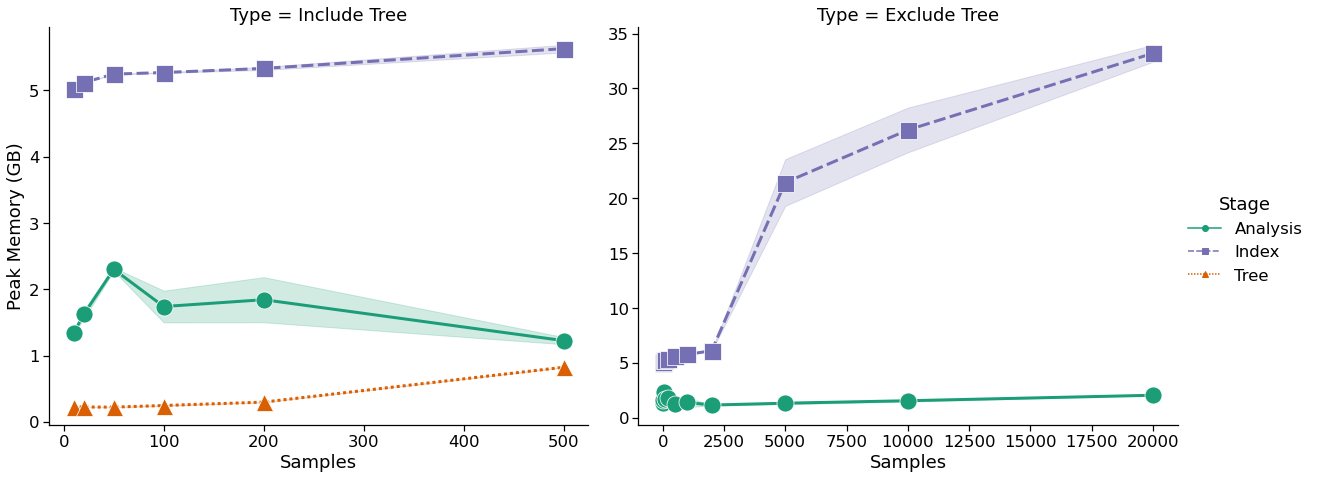

In [11]:
with sns.plotting_context("notebook", font_scale=1.5):
    g = sns.relplot(x='Samples', y='Peak Memory (GB)', hue="Stage", style="Stage", ci="sd", kind="line",
                    data=index_info_memory_df, markers=stages_markers_nototal, estimator='mean', col="Type",
                    height=7, aspect=1.2, linewidth=3, markersize=17, err_kws={"alpha": 0.2},
                    palette=stages_palette_nototal,
                    facet_kws={'sharey': False, 'sharex': False})
    plt.savefig('figures/index-memory.pdf')

#### 2.1.3.1. Mean/stddev

In [12]:
index_info_memory_df.groupby(['Samples', 'Stage', 'Type']).agg(['mean', 'std', 'count'])

Peak Memory (GB)                
                                          mean       std count
Samples Stage    Type                                         
10      Analysis Exclude Tree         1.341890  0.009124     3
                 Include Tree         1.341890  0.009124     3
        Index    Exclude Tree         5.021235  0.002043     3
                 Include Tree         5.021235  0.002043     3
        Tree     Include Tree         0.232048  0.000269     3
20      Analysis Exclude Tree         1.621136  0.067799     3
                 Include Tree         1.621136  0.067799     3
        Index    Exclude Tree         5.120307  0.000954     3
                 Include Tree         5.120307  0.000954     3
        Tree     Include Tree         0.224370  0.000687     3
50      Analysis Exclude Tree         2.302832  0.025726     3
                 Include Tree         2.302832  0.025726     3
        Index    Exclude Tree         5.247017  0.006241     3
                 Include Tree         5.247017  0.006241     3
        Tree     Include Tree         0.223250  0.000950     3
100     Analysis Exclude Tree         1.740790  0.239556     3
                 Include Tree         1.740790  0.239556     3
        Index    Exclude Tree         5.270871  0.004049     3
                 Include Tree         5.270871  0.004049     3
        Tree     Include Tree         0.247598  0.006103     3
200     Analysis Exclude Tree         1.843693  0.340268     3
                 Include Tree         1.843693  0.340268     3
        Index    Exclude Tree         5.332898  0.023355     3
                 Include Tree         5.332898  0.023355     3
        Tree     Include Tree         0.298832  0.000433     3
500     Analysis Exclude Tree         1.225619  0.053860     3
                 Include Tree         1.225619  0.053860     3
        Index    Exclude Tree         5.631563  0.057733     3
                 Include Tree         5.631563  0.057733     3
        Tree     Include Tree         0.825194  0.003005     3
1000    Analysis Exclude Tree         1.392727  0.430300     3
        Index    Exclude Tree         5.766472  0.006124     3
2000    Analysis Exclude Tree         1.157232  0.033668     3
        Index    Exclude Tree         6.108396  0.011707     3
5000    Analysis Exclude Tree         1.325153  0.094194     3
        Index    Exclude Tree        21.432804  2.130860     3
10000   Analysis Exclude Tree         1.549833  0.071319     3
        Index    Exclude Tree        26.218887  2.038093     3
20000   Analysis Exclude Tree         2.049670  0.000987     3
        Index    Exclude Tree        33.207890  0.772713     3

#### 2.1.3.2. Number of features vs memory

In [13]:
# memory_features_df = melt_memory(index_info_df,
#                                             include_tree_na=False,
#                                             id_vars=['Samples',
#                                                      'Number features (no unknown)'])
# memory_features_df = memory_features_df.rename({'Number features (no unknown)': 'Number of features'}, axis='columns')
# memory_features_df['Feature Type'] = 'Variant calls'

memory_unknown_features_df = melt_memory(index_info_df,
                                            include_tree_na=False,
                                            id_vars=['Samples',
                                                     'Number features (unknown)'])
memory_unknown_features_df = memory_unknown_features_df.rename({'Number features (unknown)': 'Number of features'}, axis='columns')
memory_unknown_features_df['Feature Type'] = 'Unknown/missing'

memory_all_features_df = melt_memory(index_info_df,
                                            include_tree_na=False,
                                            id_vars=['Samples',
                                                     'Number features (all)'])
memory_all_features_df = memory_all_features_df.rename({'Number features (all)': 'Number of features'}, axis='columns')
memory_all_features_df['Feature Type'] = 'All'

memory_features_combined_df = pd.concat([memory_unknown_features_df, memory_all_features_df])
memory_features_combined_df = memory_features_combined_df[memory_features_combined_df['Stage'] == 'Index']
memory_features_combined_df['Number of samples'] = memory_features_combined_df['Samples']
memory_features_combined_df.loc[memory_features_combined_df['Samples'] <= 2000, 'Number of samples'] = '≤ 2000'

memory_features_combined_df.tail(10)

,Samples,Number of features,Stage,Peak Memory (GB),Feature Type,Number of samples
56,2000,32480,Index,6.111019,All,≤ 2000
57,5000,35646,Index,20.335629,All,5000
58,5000,35646,Index,20.074112,All,5000
59,5000,35646,Index,23.888672,All,5000
60,10000,39068,Index,23.872482,All,10000
61,10000,39068,Index,27.548969,All,10000
62,10000,39068,Index,27.235210,All,10000
63,20000,45667,Index,33.660168,All,20000
64,20000,45667,Index,33.647835,All,20000
65,20000,45667,Index,32.315666,All,20000


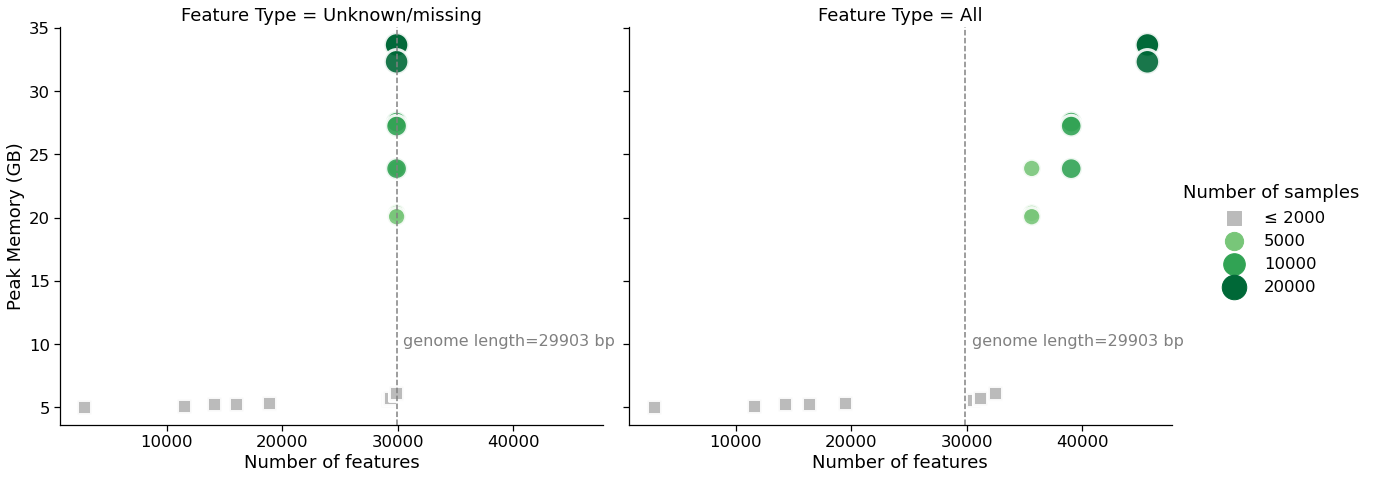

In [14]:
with sns.plotting_context("notebook", font_scale=1.5):
    g = sns.relplot(x='Number of features', y='Peak Memory (GB)', col="Feature Type",
                    size='Number of samples', style='Number of samples',
                    kind="scatter", s=100, alpha=0.9, hue='Number of samples',
                    sizes=(600, 200), palette=['#bbbbbb', '#78c679', '#31a354', '#006837'],
                    data=memory_features_combined_df, markers=["s", "o", "o", "o"],
                    height=7, aspect=1.2, linewidth=3,
                    )
    
    reference_size = index_info_df['Reference length'].value_counts().index[0]
    for ax in g.axes.flat:
        ax.axvline(reference_size, color='gray', ls='--')
        ylim = ax.get_ylim()
        ylen = ylim[1] - ylim[0]
        ypos = ylim[1] - ylen * 0.8
        xpos = reference_size + reference_size * 0.02
        ax.text(xpos, ypos, f'genome length={reference_size} bp', fontdict={'size': 16, 'color': 'gray'})
        
    plt.savefig('figures/index-memory-features.pdf')

#### 2.1.3.3. Memory batch size 10,000

In [15]:
index_info_memory_subset_df = index_info_memory_df.copy()[
    index_info_memory_df['Samples'].isin([2000, 5000, 10000, 20000])]
index_info_memory_subset_df['Sample Batch Size'] = 2000
index_info_memory_subset_df.head(5)

,Samples,Stage,Peak Memory (GB),Type,Sample Batch Size
21,2000,Analysis,1.152634,Exclude Tree,2000
22,2000,Analysis,1.126099,Exclude Tree,2000
23,2000,Analysis,1.192963,Exclude Tree,2000
24,5000,Analysis,1.223930,Exclude Tree,2000
25,5000,Analysis,1.341297,Exclude Tree,2000


In [16]:
cases_batch_paths = [cases_root_dir / f'case-{x}-batch-10000' for x in [2000, 5000, 10000, 20000]]
index_info_batch_paths = [x / 'index-info.tsv' for x in cases_batch_paths]

index_info_batch_df = read_all_df(index_info_batch_paths)
index_info_batch_df['Samples'] = index_info_batch_df['Number samples'].astype(int)
index_info_batch_df.head(4)

,Name,Iteration,Number samples,Number features (all),Number features (no unknown),Number cores,Reference length,Analysis runtime,Analysis memory (max),Analysis memory (max/process),...,Index runtime,Index memory (max),Index memory (max/process),Index size,Tree runtime,Tree memory (max),Tree memory (max/process),Total runtime,Max memory,Samples
0,case-2000-batch-10000,1,2000,32480,2647,32,29903,812.86,1.333563e+09,378245120.0,...,106.79,6.563570e+09,1.210864e+09,39849984.0,NaN,NaN,NaN,919.65,6.563570e+09,2000
1,case-2000-batch-10000,2,2000,32480,2647,32,29903,801.29,1.244619e+09,379973632.0,...,106.99,6.574125e+09,1.211961e+09,39821312.0,NaN,NaN,NaN,908.28,6.574125e+09,2000
2,case-2000-batch-10000,3,2000,32480,2647,32,29903,814.67,1.210757e+09,372658176.0,...,105.97,6.566113e+09,1.219965e+09,39845888.0,NaN,NaN,NaN,920.64,6.566113e+09,2000
3,case-5000-batch-10000,1,5000,35646,5743,32,29903,1857.95,1.519378e+09,537124864.0,...,250.85,8.375648e+09,2.995818e+09,94470144.0,NaN,NaN,NaN,2108.80,8.375648e+09,5000


In [17]:
index_info_memory_batch_df = melt_and_combine_with_without_tree(index_info_batch_df,
                                                          melt_func=melt_memory,
                                                          id_vars='Samples')
index_info_memory_batch_df['Sample Batch Size'] = 10000
index_info_memory_batch_df.head(5)

,Samples,Stage,Peak Memory (GB),Type,Sample Batch Size
0,2000,Analysis,1.241978,Exclude Tree,10000
1,2000,Analysis,1.159142,Exclude Tree,10000
2,2000,Analysis,1.127605,Exclude Tree,10000
3,5000,Analysis,1.415031,Exclude Tree,10000
4,5000,Analysis,1.464931,Exclude Tree,10000


In [18]:
memory_batch_combined_df = pd.concat([index_info_memory_subset_df, index_info_memory_batch_df])
memory_batch_combined_df = memory_batch_combined_df[memory_batch_combined_df['Stage'] == 'Index']
memory_batch_combined_df = memory_batch_combined_df.rename({
    'Peak Memory (GB)': 'Peak Memory for Index (GB)'}, axis='columns')
memory_batch_combined_df

,Samples,Stage,Peak Memory for Index (GB),Type,Sample Batch Size
54,2000,Index,6.095600,Exclude Tree,2000
55,2000,Index,6.118568,Exclude Tree,2000
56,2000,Index,6.111019,Exclude Tree,2000
57,5000,Index,20.335629,Exclude Tree,2000
58,5000,Index,20.074112,Exclude Tree,2000
59,5000,Index,23.888672,Exclude Tree,2000
60,10000,Index,23.872482,Exclude Tree,2000
61,10000,Index,27.548969,Exclude Tree,2000
62,10000,Index,27.235210,Exclude Tree,2000
63,20000,Index,33.660168,Exclude Tree,2000


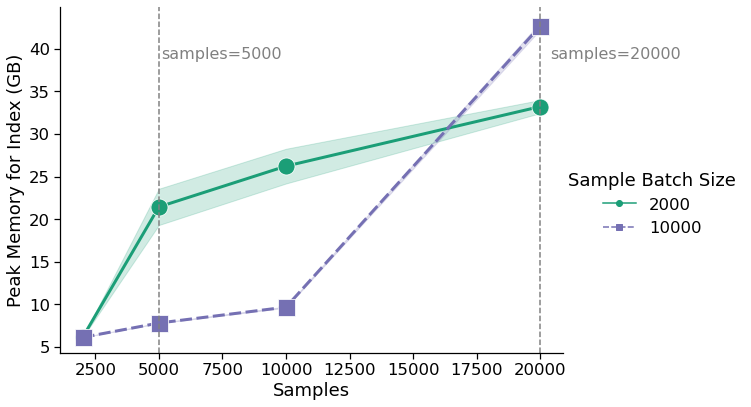

In [19]:
with sns.plotting_context("notebook", font_scale=1.5):
    batch_palette = ['#1b9e77', '#7570b3']
    batch_markers = ['o', 's']
    
    g = sns.relplot(x='Samples', y='Peak Memory for Index (GB)', hue="Sample Batch Size", 
                    style="Sample Batch Size", ci="sd", kind="line",
                    data=memory_batch_combined_df, estimator='mean',
                    markers=batch_markers,
                    palette=batch_palette,
                    height=6, aspect=1.4, linewidth=3, markersize=17, err_kws={"alpha": 0.2})
    
    for ax in g.axes.flat:
        for line in [5000, 20000]:
            ax.axvline(line, color='gray', ls='--')
            ylim = ax.get_ylim()
            ylen = ylim[1] - ylim[0]
            ypos = ylim[1] - ylen * 0.15
            xpos = line + line * 0.02
            ax.text(xpos, ypos, f'samples={line}', fontdict={'size': 16, 'color': 'gray'})
    plt.savefig('figures/index-memory-sample-batch-size.pdf')

### 2.1.4. Disk usage plots

In [20]:
def melt_disk_usage(df: pd.DataFrame, id_vars: str) -> pd.DataFrame:
    df = df.copy()
    df['Total size'] = df['Analysis disk uage'] + df['Index size']
    df = pd.melt(df, id_vars=id_vars,
            value_vars=['Analysis disk uage', 'Index size', 'Total size'])
    df['value'] = df['value'].apply(lambda x: x/(1024**3))
    df = df.rename({'variable': 'Stage', 'value': 'Disk (GB)'}, axis='columns')
    df['Stage'] = df['Stage'].str.replace(' disk uage', '', regex=False)
    df['Stage'] = df['Stage'].str.replace(' size', '', regex=False)
    return df
index_info_disk_df = melt_disk_usage(index_info_df, id_vars='Samples')
index_info_disk_df.head(3)

,Samples,Stage,Disk (GB)
0,10,Analysis,3.214535
1,10,Analysis,3.214535
2,10,Analysis,3.214535


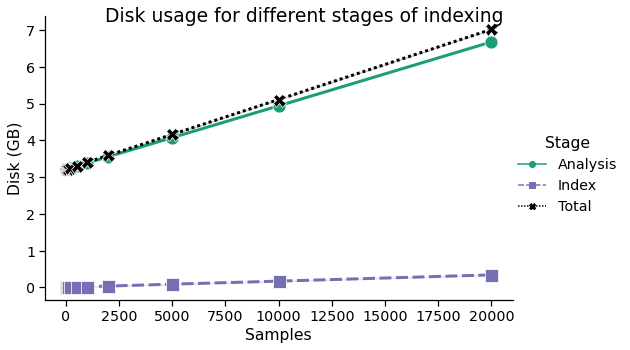

In [21]:
with sns.plotting_context("notebook", font_scale=1.3):
    g = sns.relplot(x='Samples', y='Disk (GB)', hue="Stage", style="Stage", ci="sd", kind="line",
                    data=index_info_disk_df, markers=stages_markers_notree, estimator='mean',
                    palette=stages_palette_notree,
                    height=5, aspect=1.5, linewidth=3, markersize=13, err_kws={"alpha": 0.2})
    g.fig.suptitle("Disk usage for different stages of indexing")
    plt.savefig('figures/index-disk-usage.pdf')

#### 2.1.4.1. Mean/stddev

In [22]:
index_info_disk_df.groupby(['Samples', 'Stage']).agg(['mean', 'std', 'count'])

Disk (GB)                
                      mean       std count
Samples Stage                             
10      Analysis  3.214535  0.000000     3
        Index     0.000708  0.000002     3
        Total     3.215243  0.000002     3
20      Analysis  3.216218  0.000011     3
        Index     0.001825  0.000002     3
        Total     3.218043  0.000012     3
50      Analysis  3.221383  0.000002     3
        Index     0.002630  0.000002     3
        Total     3.224013  0.000002     3
100     Analysis  3.230003  0.000010     3
        Index     0.003684  0.000004     3
        Total     3.233687  0.000006     3
200     Analysis  3.247318  0.000004     3
        Index     0.005670  0.000011     3
        Total     3.252988  0.000008     3
500     Analysis  3.298817  0.000334     3
        Index     0.012351  0.000002     3
        Total     3.311167  0.000335     3
1000    Analysis  3.384733  0.000021     3
        Index     0.020514  0.000004     3
        Total     3.405247  0.000023     3
2000    Analysis  3.557143  0.000013     3
        Index     0.037111  0.000024     3
        Total     3.594254  0.000027     3
5000    Analysis  4.073921  0.000019     3
        Index     0.088666  0.000017     3
        Total     4.162587  0.000031     3
10000   Analysis  4.939344  0.000126     3
        Index     0.171045  0.000006     3
        Total     5.110388  0.000124     3
20000   Analysis  6.677498  0.000138     3
        Index     0.340841  0.000146     3
        Total     7.018339  0.000130     3

# 3. Querying

## 3.1. Querying API

In [23]:
query_paths = [x / 'query-api.tsv' for x in cases_paths]
query_paths = [x for x in query_paths if x.exists()]

query_df = read_all_df(query_paths)
query_df['Samples'] = query_df['Name'].str.extract(r'^case-(\d+)').astype(int)
query_df['Time'] = query_df['Time'].apply(lambda x: x * 1000)
query_df['Number of features (thousands)'] = query_df['Number features (all)'] / 1000
query_df = query_df.rename({'Time': 'Time (ms)'}, axis='columns')

# Remove isin queries to ignore queries involving a tree
query_df = query_df[~query_df['Kind'].str.contains('isin')]

# Remove db.samples_query since I don't really need the times
query_df = query_df[~query_df['Kind'].str.contains('db.samples_query')]

# Divide up kinds of queries into classes
query_df['Time scale'] = 'Short'
query_df.loc[query_df['Kind'].isin(
    ['q.toframe', 'q.hasa', 'q.join', 'q.features_summary']), 'Time scale'] = 'Medium'
query_df.loc[query_df['Kind'].isin(
    ['q.features_comparison']), 'Time scale'] = 'Long'

query_df = query_df.sort_values('Time scale', ascending=False)

query_df.head(5)

,Name,Kind,Number samples,Number features (no unknown),Number features (all),Number executions,Iteration,Time (ms),Samples,Number of features (thousands),Time scale
600,case-500,q.isa,500,1396,30529,1000,1,0.377742,500,30.529,Short
616,case-500,q AND r,500,1396,30529,10000,7,0.021635,500,30.529,Short
638,case-500,q.summary,500,1396,30529,1000,9,0.354879,500,30.529,Short
637,case-500,q.summary,500,1396,30529,1000,8,0.362267,500,30.529,Short
636,case-500,q.summary,500,1396,30529,1000,7,0.354650,500,30.529,Short


### 3.1.1. Compare runtime for single set of samples

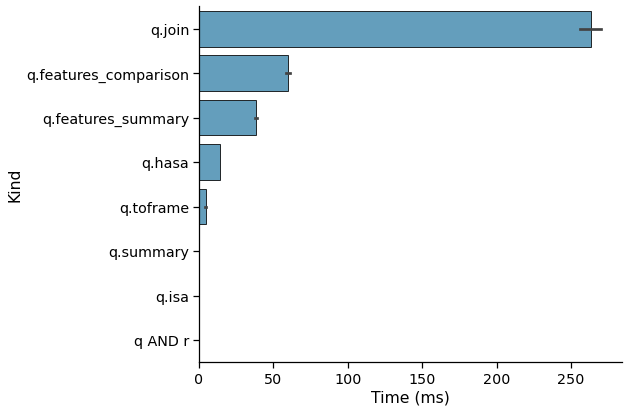

In [24]:
query_samples = query_df[query_df['Samples'] == 100]
query_samples = query_samples.sort_values('Time (ms)', ascending=False)
query_samples

with sns.plotting_context("notebook", font_scale=1.3):
    g = sns.catplot(
        data=query_samples, kind="bar",
        y="Kind", x="Time (ms)", hue=None,
        ci="sd", height=6, aspect=1.5, alpha=0.8, color="#2b8cbe", edgecolor="black"
    )
    plt.savefig('figures/query-api-runtime-100.pdf')

### 3.1.2. Compare runtime vs. all samples

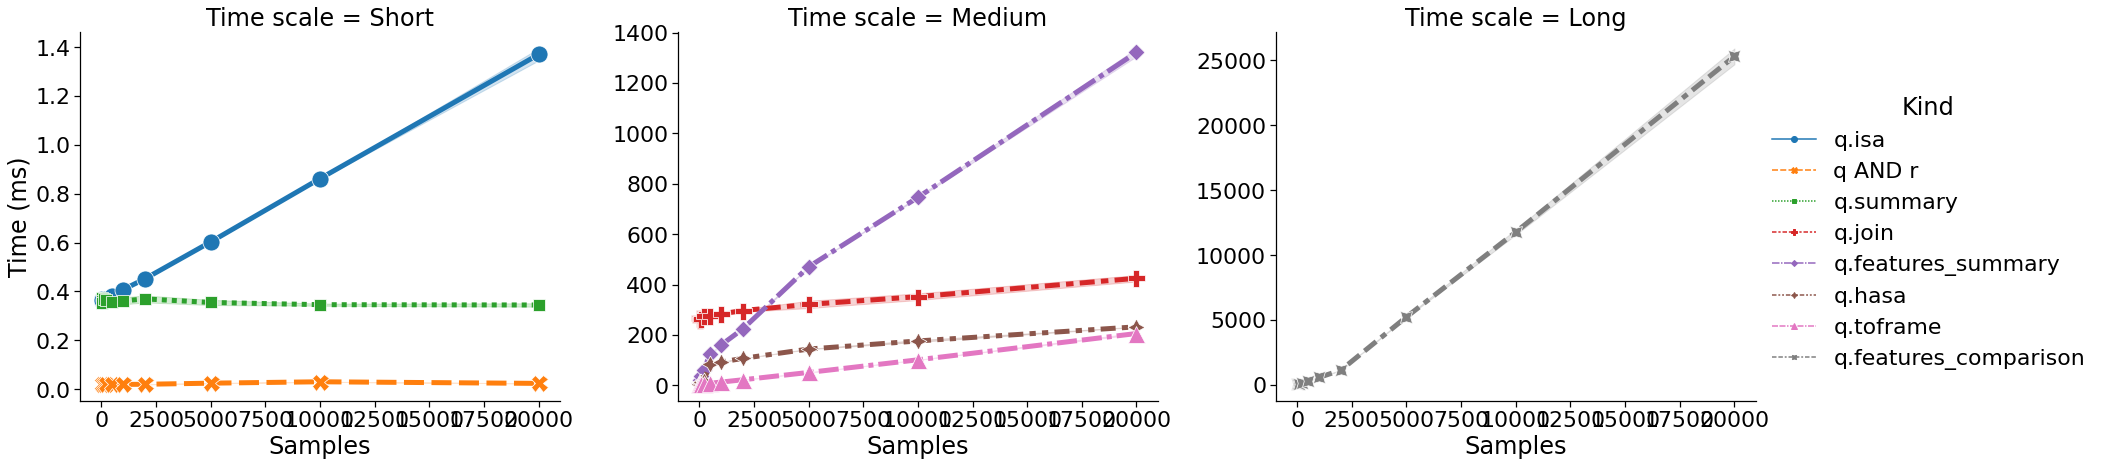

In [25]:
with sns.plotting_context("notebook", font_scale=2):
    g = sns.relplot(x='Samples', y='Time (ms)', hue="Kind", style="Kind", ci="sd", kind="line",
                    data=query_df, markers=True, estimator='mean', col="Time scale",
                    height=7, aspect=1.2, linewidth=5, markersize=17, err_kws={"alpha": 0.2},
                    facet_kws={'sharey': False, 'sharex': True})
    plt.savefig('figures/query-api-runtime.pdf')

#### 3.1.2.1. mean/stdev

In [26]:
query_mean_df = query_df.groupby(['Name', 'Kind']).agg({'Time (ms)': ['mean', 'std', 'count'],
                                                        'Number features (all)': ['mean', 'std']})
query_mean_df.loc[['case-2000', 'case-5000', 'case-10000', 'case-20000']]

Time (ms)                    \
                                          mean         std count   
Name       Kind                                                    
case-2000  q AND r                    0.020185    0.000253    10   
           q.features_comparison   1116.996609   12.939354    10   
           q.features_summary       224.417978    4.925988    10   
           q.hasa                   107.116756    0.184790    10   
           q.isa                      0.452030    0.004214    10   
           q.join                   296.876112    5.314710    10   
           q.summary                  0.369349    0.014051    10   
           q.toframe                 22.137027    0.073372    10   
case-5000  q AND r                    0.024702    0.000090    10   
           q.features_comparison   5222.537889   38.206904    10   
           q.features_summary       470.062567    0.770037    10   
           q.hasa                   143.902545    0.704554    10   
           q.isa                      0.602546    0.000624    10   
           q.join                   321.069713   14.461650    10   
           q.summary                  0.354944    0.010546    10   
           q.toframe                 51.102814    0.114775    10   
case-10000 q AND r                    0.030392    0.000067    10   
           q.features_comparison  11767.065590  204.891686    10   
           q.features_summary       745.861265    2.799578    10   
           q.hasa                   176.073574    3.563806    10   
           q.isa                      0.861430    0.002645    10   
           q.join                   351.776566   13.296527    10   
           q.summary                  0.345832    0.004301    10   
           q.toframe                101.242789    0.234977    10   
case-20000 q AND r                    0.023818    0.000057    10   
           q.features_comparison  25315.924053  610.519065    10   
           q.features_summary      1321.005183   15.766561    10   
           q.hasa                   232.202225    0.393190    10   
           q.isa                      1.369443    0.024696    10   
           q.join                   424.647757   12.646817    10   
           q.summary                  0.344601    0.006989    10   
           q.toframe                205.639208    2.904276    10   

                                 Number features (all)       
                                                  mean  std  
Name       Kind                                              
case-2000  q AND r                             32480.0  0.0  
           q.features_comparison               32480.0  0.0  
           q.features_summary                  32480.0  0.0  
           q.hasa                              32480.0  0.0  
           q.isa                               32480.0  0.0  
           q.join                              32480.0  0.0  
           q.summary                           32480.0  0.0  
           q.toframe                           32480.0  0.0  
case-5000  q AND r                             35646.0  0.0  
           q.features_comparison               35646.0  0.0  
           q.features_summary                  35646.0  0.0  
           q.hasa                              35646.0  0.0  
           q.isa                               35646.0  0.0  
           q.join                              35646.0  0.0  
           q.summary                           35646.0  0.0  
           q.toframe                           35646.0  0.0  
case-10000 q AND r                             39068.0  0.0  
           q.features_comparison               39068.0  0.0  
           q.features_summary                  39068.0  0.0  
           q.hasa                              39068.0  0.0  
           q.isa                               39068.0  0.0  
           q.join                              39068.0  0.0  
           q.summary                           39068.0  0.0  
           q.toframe                        

### 3.1.3. Compare runtime vs. number of features

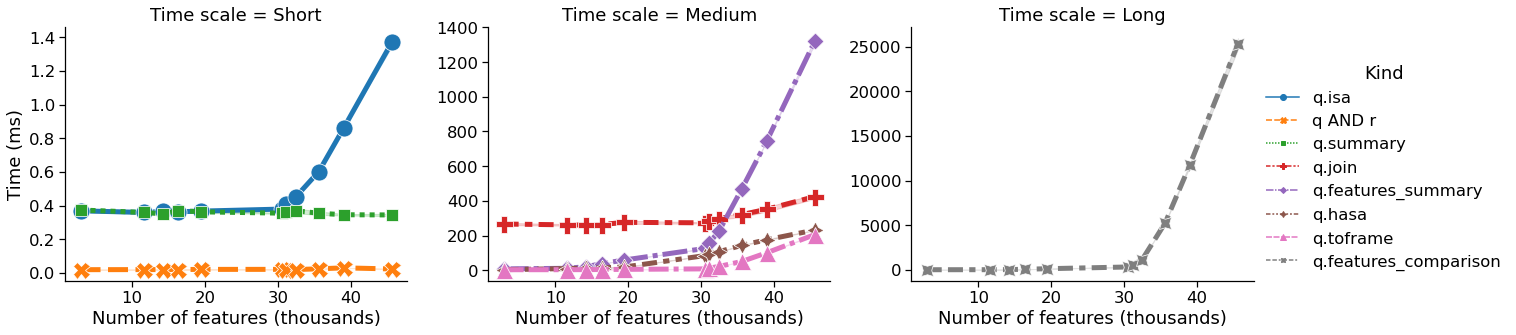

In [27]:
with sns.plotting_context("notebook", font_scale=1.5):
    g = sns.relplot(x='Number of features (thousands)', y='Time (ms)', hue="Kind", style="Kind",
                    ci="sd", kind="line",
                    data=query_df, markers=True, estimator='mean', col="Time scale",
                    height=5, aspect=1.2, linewidth=5, markersize=17, err_kws={"alpha": 0.2},
                    facet_kws={'sharey': False, 'sharex': True})
    plt.savefig('figures/query-api-runtime-features.pdf')

## 3.2. Querying CLI

In [28]:
query_paths_cli = [x / 'query-cli.tsv' for x in cases_paths]
query_paths_cli = [x for x in query_paths_cli if x.exists()]
query_cli_df = read_all_df(query_paths_cli)
query_cli_df['Samples'] = query_cli_df['Name'].str.extract(r'^case-(\d+)').astype(int)
query_cli_df['Time (ms)'] = query_cli_df['Runtime'].apply(lambda x: x * 1000)
query_cli_df['Memory (MB)'] = query_cli_df['Memory (max)'].apply(lambda x: x / (1024**2))
query_cli_df['Number of features (thousands)'] = query_cli_df['Number features (all)'] / 1000
query_cli_df['Number of unknown features (thousands)'] = (query_cli_df['Number features (all)'] - \
                                                          query_cli_df['Number features (no unknown)']) / 1000

# Remove isin queries to ignore queries involving a tree
query_cli_df = query_cli_df[~query_cli_df['Kind'].str.contains('isin')]

query_cli_df.head(5)

,Name,Kind,Iteration,Number samples,Number features (no unknown),Number features (all),Runtime,Memory (max),Mmemory (max/process),Samples,Time (ms),Memory (MB),Number of features (thousands),Number of unknown features (thousands)
0,case-10,query hasa,1,10,44,2900,2.95,218714112.0,218714112.0,10,2950.0,208.582031,2.9,2.856
1,case-10,query hasa,2,10,44,2900,2.77,218562560.0,218562560.0,10,2770.0,208.437500,2.9,2.856
2,case-10,query hasa,3,10,44,2900,2.72,218771456.0,218771456.0,10,2720.0,208.636719,2.9,2.856
3,case-10,query hasa,4,10,44,2900,2.78,218378240.0,218378240.0,10,2780.0,208.261719,2.9,2.856
4,case-10,query hasa,5,10,44,2900,2.59,218669056.0,218669056.0,10,2590.0,208.539062,2.9,2.856


### 3.2.1. Compare runtime for single set of samples

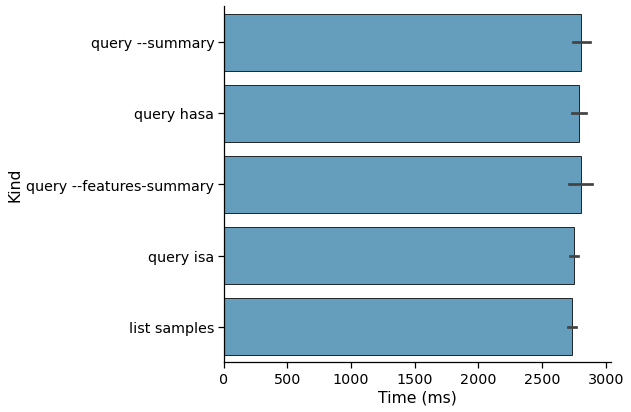

In [29]:
query_cli_samples = query_cli_df[query_cli_df['Samples'] == 100]
query_cli_samples = query_cli_samples.sort_values('Time (ms)', ascending=False)

with sns.plotting_context("notebook", font_scale=1.3):
    g = sns.catplot(data=query_cli_samples, kind="bar",
                  y="Kind", x="Time (ms)", hue=None,
                  ci="sd", height=6, aspect=1.5, alpha=0.8,
                  color="#2b8cbe", edgecolor="black")
    plt.savefig('figures/query-cli-runtime-100.pdf')

#### 3.2.1.1. Compare runtime between CLI and API

In [30]:
qcli = query_cli_samples.loc[:, ['Name', 'Kind', 'Number samples', 'Time (ms)']]
qcli['Kind'] = qcli['Kind'].replace({
        'query isa': 'isa',
        'query hasa': 'hasa',
        'query isin': 'isin',
        'query --features-summary': 'features summary',
    })
qcli['Method'] = 'CLI'
qapi = query_samples.loc[:, ['Name', 'Kind', 'Number samples', 'Time (ms)']]
qapi['Kind'] = qapi['Kind'].replace({
        'q.isa': 'isa',
        'q.hasa': 'hasa',
        'q.isin': 'isin',
        'q.features_summary': 'features summary',
    })
qapi['Method'] = 'API'

q_cli_api = pd.concat([qcli, qapi])
q_cli_api = q_cli_api[q_cli_api['Kind'].isin(['isa', 'hasa', 'isin', 'features summary'])]
q_cli_api = q_cli_api.sort_values(['Time (ms)'])
q_cli_api.head(3)

,Name,Kind,Number samples,Time (ms),Method
383,case-100,isa,100,0.362965,API
386,case-100,isa,100,0.363007,API
382,case-100,isa,100,0.363027,API


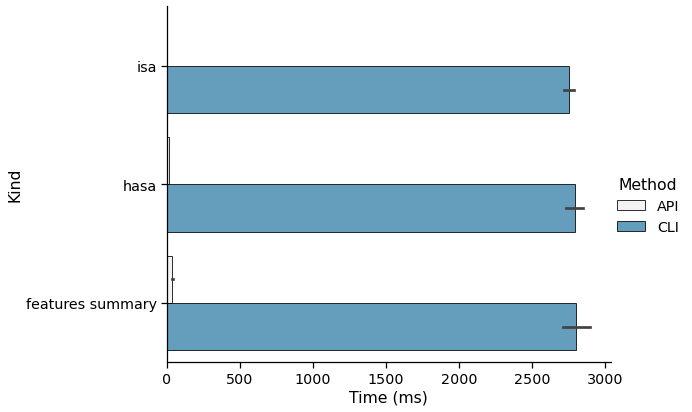

In [31]:
with sns.plotting_context("notebook", font_scale=1.3):
    g = sns.catplot(data=q_cli_api, kind="bar",
                  y="Kind", x="Time (ms)", hue='Method',
                  ci="sd", height=6, aspect=1.5, alpha=0.8,
                  color="#2b8cbe", edgecolor="black")
    plt.savefig('figures/query-cli-api-runtime-100.pdf')

### 3.2.2. Compare runtime to number of samples

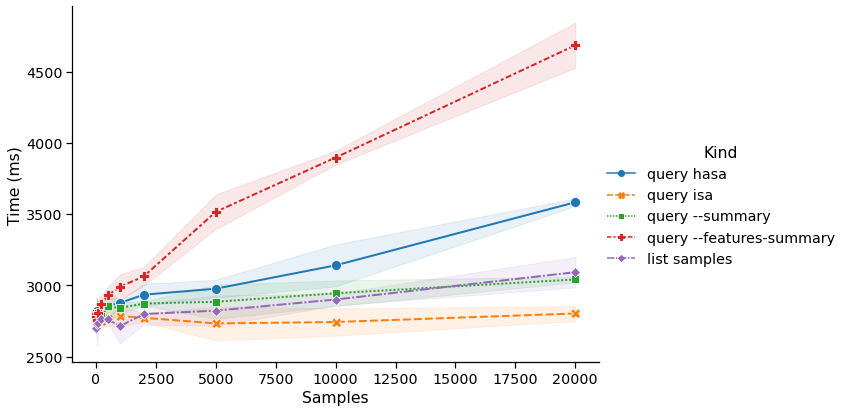

In [77]:
with sns.plotting_context("notebook", font_scale=1.3):
    g = sns.relplot(x='Samples', y='Time (ms)', hue="Kind", ci="sd", kind="line",
                    data=query_cli_df, style="Kind", markers=True, estimator='mean',
                    height=6, aspect=1.5, linewidth=2, markersize=10, err_kws={"alpha": 0.1})
    plt.savefig('figures/query-cli-runtime.pdf')

#### 3.2.2.1. Mean/stdev

In [67]:
query_mean_df = query_cli_df.groupby(['Name', 'Kind']).agg({'Time (ms)': ['mean', 'std', 'count'],
                                                            'Number features (all)': ['mean', 'std']})
query_mean_df.loc[['case-10', 'case-20', 'case-2000', 'case-5000', 'case-10000', 'case-20000']]

Time (ms)                    \
                                         mean         std count   
Name       Kind                                                   
case-10    list samples                2697.0   42.700507    10   
           query --features-summary    2798.0   53.082745    10   
           query --summary             2806.0   58.156876    10   
           query hasa                  2779.0  101.702180    10   
           query isa                   2777.0   77.753171    10   
case-20    list samples                2704.0   51.897335    10   
           query --features-summary    2778.0   32.930904    10   
           query --summary             2803.0  114.411538    10   
           query hasa                  2780.0   61.644140    10   
           query isa                   2764.0   99.241568    10   
case-2000  list samples                2799.0   74.004504    10   
           query --features-summary    3064.0   64.841688    10   
           query --summary             2873.0   14.944341    10   
           query hasa                  2935.0   76.194196    10   
           query isa                   2773.0   30.203017    10   
case-5000  list samples                2823.0  106.567662    10   
           query --features-summary    3517.0  122.024588    10   
           query --summary             2885.0  119.930535    10   
           query hasa                  2977.0   62.725150    10   
           query isa                   2733.0  118.888370    10   
case-10000 list samples                2901.0   42.282121    10   
           query --features-summary    3898.0   48.944413    10   
           query --summary             2945.0   89.845546    10   
           query hasa                  3141.0  147.154492    10   
           query isa                   2743.0   96.038187    10   
case-20000 list samples                3093.0  106.045064    10   
           query --features-summary    4687.0  158.888500    10   
           query --summary             3042.0   19.888579    10   
           query hasa                  3584.0   26.749870    10   
           query isa                   2803.0   52.925524    10   

                                    Number features (all)       
                                                     mean  std  
Name       Kind                                                 
case-10    list samples                            2900.0  0.0  
           query --features-summary                2900.0  0.0  
           query --summary                         2900.0  0.0  
           query hasa                              2900.0  0.0  
           query isa                               2900.0  0.0  
case-20    list samples                           11560.0  0.0  
           query --features-summary               11560.0  0.0  
           query --summary                        11560.0  0.0  
           query hasa                             11560.0  0.0  
           query isa                              11560.0  0.0  
case-2000  list samples                           32480.0  0.0  
           query --features-summary               32480.0  0.0  
           query --summary                        32480.0  0.0  
           query hasa                             32480.0  0.0  
           query isa                              32480.0  0.0  
case-5000  list samples                           35646.0  0.0  
           query --features-summary               35646.0  0.0  
           query --summary                        35646.0  0.0  
           query hasa                             35646.0  0.0  
           query isa                              35646.0  0.0  
case-10000 list samples                           39068.0  0.0  
           query --features-summary               39068.0  0.0  
           query --summary                        39068.0  0.0  
           query hasa                             39068.0  0.0  
           query isa                              39068.0  0.0  
case

In [76]:
query_mean_df['Time (ms)', 'mean'].min()

2697.0

### 3.2.3. Compare peak memory to number of samples

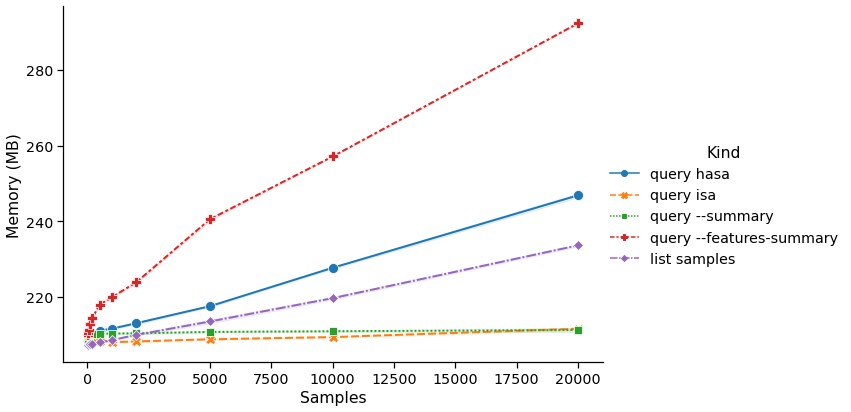

In [68]:
with sns.plotting_context("notebook", font_scale=1.3):
    g = sns.relplot(x='Samples', y='Memory (MB)', hue="Kind", style="Kind", ci="sd", kind="line",
                    data=query_cli_df, markers=True, estimator='mean',
                    height=6, aspect=1.5, linewidth=2, markersize=10, err_kws={"alpha": 0.1})
    plt.savefig('figures/query-cli-memory.pdf')

#### 3.2.3.1. Mean/stddev

In [35]:
query_mean_df = query_cli_df.groupby(['Name', 'Kind']).agg({'Memory (MB)': ['mean', 'std', 'count'],
                                                            'Number features (all)': ['mean', 'std']})
query_mean_df.loc[['case-2000', 'case-5000', 'case-10000', 'case-20000']]

Memory (MB)                  \
                                           mean       std count   
Name       Kind                                                   
case-2000  list samples              210.063281  0.246013    10   
           query --features-summary  223.973047  0.334341    10   
           query --summary           210.472656  0.246476    10   
           query hasa                213.139062  0.329534    10   
           query isa                 208.319922  0.178670    10   
case-5000  list samples              213.589844  0.515191    10   
           query --features-summary  240.604297  0.349206    10   
           query --summary           210.841406  0.190942    10   
           query hasa                217.631250  0.237024    10   
           query isa                 208.888672  0.243627    10   
case-10000 list samples              219.747656  0.356291    10   
           query --features-summary  257.166016  0.136728    10   
           query --summary           211.017188  0.177935    10   
           query hasa                227.770703  0.282507    10   
           query isa                 209.475000  0.136579    10   
case-20000 list samples              233.691016  0.302546    10   
           query --features-summary  292.345312  0.150538    10   
           query --summary           211.342187  0.579479    10   
           query hasa                246.903125  0.532642    10   
           query isa                 211.674219  0.394985    10   

                                    Number features (all)       
                                                     mean  std  
Name       Kind                                                 
case-2000  list samples                           32480.0  0.0  
           query --features-summary               32480.0  0.0  
           query --summary                        32480.0  0.0  
           query hasa                             32480.0  0.0  
           query isa                              32480.0  0.0  
case-5000  list samples                           35646.0  0.0  
           query --features-summary               35646.0  0.0  
           query --summary                        35646.0  0.0  
           query hasa                             35646.0  0.0  
           query isa                              35646.0  0.0  
case-10000 list samples                           39068.0  0.0  
           query --features-summary               39068.0  0.0  
           query --summary                        39068.0  0.0  
           query hasa                             39068.0  0.0  
           query isa                              39068.0  0.0  
case-20000 list samples                           45667.0  0.0  
           query --features-summary               45667.0  0.0  
           query --summary                        45667.0  0.0  
           query hasa                             45667.0  0.0  
           query isa                              45667.0  0.0

### 3.2.4. Compare runtime to number of features

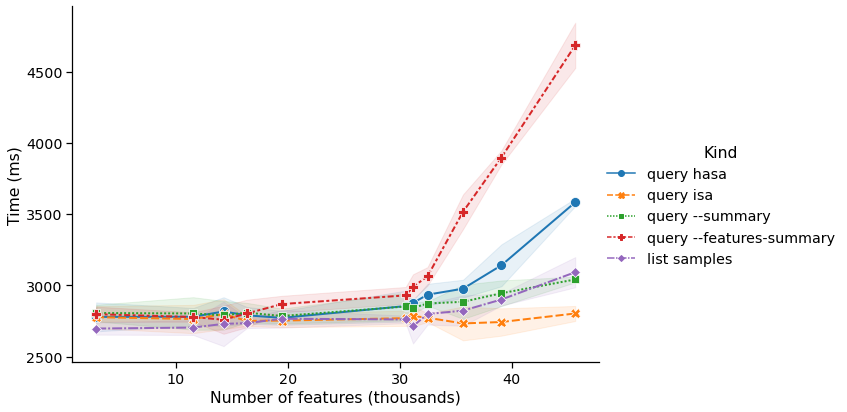

In [36]:
# with sns.plotting_context("notebook", font_scale=1.3):
#     g = sns.relplot(x='Number of features (thousands)', y='Time (ms)', col="Kind", ci="sd", kind="line",
#                     data=query_cli_df, marker="o", estimator='mean',
#                    facet_kws={'sharey': True, 'sharex': True}, col_wrap=3, height=5)
    
with sns.plotting_context("notebook", font_scale=1.3):
    g = sns.relplot(x='Number of features (thousands)', y='Time (ms)', hue="Kind", ci="sd", kind="line",
                    data=query_cli_df, markers=True, estimator='mean', style="Kind",
                   height=6, aspect=1.5, linewidth=2, markersize=10, err_kws={"alpha": 0.1})
    plt.savefig('figures/query-cli-runtime-features.pdf')

### 3.2.5. Compare peak memory to number of features

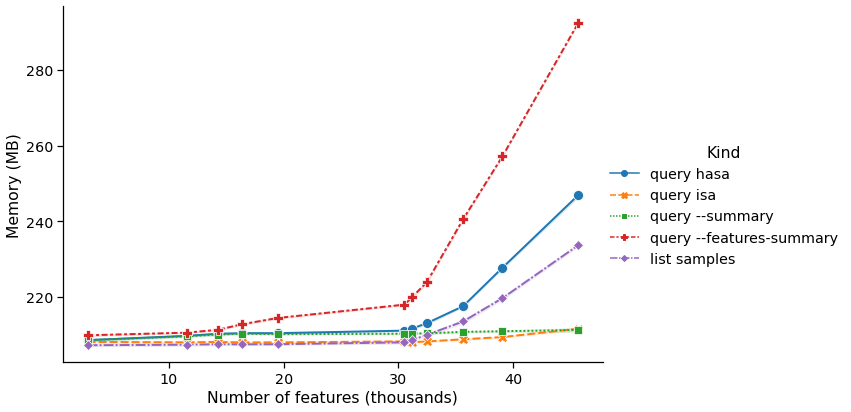

In [37]:
# with sns.plotting_context("notebook", font_scale=1.3):
#     g = sns.relplot(x='Number of features (thousands)', y='Memory (MB)', col="Kind", ci="sd", kind="line",
#                     data=query_cli_df, marker="o", estimator='mean',
#                    facet_kws={'sharey': True, 'sharex': True}, col_wrap=3, height=5)
    
with sns.plotting_context("notebook", font_scale=1.3):
    g = sns.relplot(x='Number of features (thousands)', y='Memory (MB)', hue="Kind", ci="sd", kind="line",
                    data=query_cli_df, markers=True, estimator='mean', style="Kind",
                   height=6, aspect=1.5, linewidth=2, markersize=10, err_kws={"alpha": 0.1})
    plt.savefig('figures/query-cli-memory-features.pdf')

# 4. Tree vs. clustering

## 4.1. Connect to index and metadata file

In [38]:
import genomics_data_index.api as gdi

number_samples = 500
min_samples_cluster = 2

clustering_index = cases_root_dir / f'case-{number_samples}' / 'index'
db = gdi.GenomicsDataIndex.connect(clustering_index)
db

<GenomicsDataIndex(samples=500)>

In [39]:
import pandas as pd

metadata_df = pd.read_csv(metadata_file, sep='\t')
metadata_df.head(2)

,strain,virus,gisaid_epi_isl,genbank_accession,sra_accession,date,region,country,division,location,...,ambiguity_score,scorpio_call,scorpio_support,scorpio_conflict,version,pangolin_version,pangoLEARN_version,pango_version,status,note
0,OU420663,ncov,?,OU420663,ERR5939958,2020,Europe,United Kingdom,England,NaN,...,1.00000,Alpha (B.1.1.7-like),1.0,0.0,PLEARN-v1.2.66,3.1.11,2021-08-24,v1.2.66,passed_qc,scorpio call: Alt alleles 23; Ref alleles 0; A...
1,USA/NY-CUIMC-NP-3606/2020,ncov,?,MZ702266,NaN,2020-12-02,North America,USA,New York,New York City,...,0.95097,NaN,NaN,NaN,PLEARN-v1.2.66,3.1.11,2021-08-24,v1.2.66,passed_qc,NaN


In [40]:
metadata_df.columns

Index(['strain', 'virus', 'gisaid_epi_isl', 'genbank_accession',
       'sra_accession', 'date', 'region', 'country', 'division', 'location',
       'region_exposure', 'country_exposure', 'division_exposure', 'segment',
       'length', 'host', 'age', 'sex', 'Nextstrain_clade', 'pango_lineage',
       'GISAID_clade', 'originating_lab', 'submitting_lab', 'authors', 'url',
       'title', 'paper_url', 'date_submitted', 'sampling_strategy',
       'missing_data', 'divergence', 'nonACGTN', 'rare_mutations',
       'snp_clusters', 'QC_missing_data', 'QC_mixed_sites',
       'QC_rare_mutations', 'QC_snp_clusters', 'clock_deviation',
       'missing_data_percent', 'taxon', 'lineage', 'conflict',
       'ambiguity_score', 'scorpio_call', 'scorpio_support',
       'scorpio_conflict', 'version', 'pangolin_version', 'pangoLEARN_version',
       'pango_version', 'status', 'note'],
      dtype='object')

In [41]:
metadata_df[metadata_df['lineage'].str.match('^[^.][^.]')]['lineage'].value_counts()

AY.4      11346
None        772
AY.5        689
AY.9        554
AY.25       545
AY.3        350
AY.6        342
AY.12       334
AD.2        235
AY.7        183
AY.14       119
AY.8        108
AY.10       107
AY.2         89
AY.20        75
AY.15        53
AY.13        52
AY.11        50
AY.24        46
AY.3.1       26
AY.19        19
AY.23        18
AY.1         15
AV.1         14
AY.7.1        8
AY.16         7
AA.1          7
AP.1          5
AZ.2          5
AY.7.2        4
AY.21         4
AY.22         4
AN.1          4
AK.1          4
AS.2          3
XA            3
AE.2          3
AZ.3          3
AG.1          2
AZ.2.1        2
AA.3          1
AE.6          1
AE.7          1
AA.5          1
AU.2          1
AS.1          1
AF.1          1
AE.8          1
AZ.4          1
AA.4          1
AM.1          1
AC.1          1
Name: lineage, dtype: int64

### 4.1.1. Expand lineages so they are hierarchical

Some lineages have 2-character top-level codes which are aliases for other lineages (e.g., `AY` is an alias for `B.1.617.2`, https://cov-lineages.org/lineage_list.html). In order for my cluster comparison code to work I need to expand these lineages back to their long-form version. I am doing this here.

Note: I'm only expanding lineages I've observed in my final tree. In particular:

`AY` is an alias for `B.1.617.2` while `AV` is an alias for `B.1.1.482` (https://cov-lineages.org/lineage_list.html).

In [42]:
import re

metadata_expaneded_lineages_df = metadata_df.copy()
metadata_expaneded_lineages_df['lineage'] = metadata_expaneded_lineages_df['lineage'].apply(lambda x: re.sub(r'^AY', r'B.1.617.2', x))
metadata_expaneded_lineages_df['lineage'] = metadata_expaneded_lineages_df['lineage'].apply(lambda x: re.sub(r'^AV', r'B.1.1.482', x))

metadata_expaneded_lineages_df[metadata_expaneded_lineages_df['lineage'].str.match('B.1.617.2') | 
                              metadata_expaneded_lineages_df['lineage'].str.match('B.1.1.482')]['lineage'].value_counts()

B.1.617.2.4      11346
B.1.617.2         5418
B.1.617.2.5        689
B.1.617.2.9        554
B.1.617.2.25       545
B.1.617.2.3        350
B.1.617.2.6        342
B.1.617.2.12       334
B.1.617.2.7        183
B.1.617.2.14       119
B.1.617.2.8        108
B.1.617.2.10       107
B.1.617.2.2         89
B.1.617.2.20        75
B.1.617.2.15        53
B.1.617.2.13        52
B.1.617.2.11        50
B.1.617.2.24        46
B.1.617.2.3.1       26
B.1.617.2.19        19
B.1.617.2.23        18
B.1.617.2.1         15
B.1.1.482.1         14
B.1.617.2.7.1        8
B.1.617.2.16         7
B.1.617.2.21         4
B.1.617.2.7.2        4
B.1.617.2.22         4
Name: lineage, dtype: int64

## 4.2. Initiate query

In [43]:
q = db.samples_query(reference_name='NC_045512', universe='mutations').set_outgroup('NC_045512')\
      .join(metadata_expaneded_lineages_df, sample_names_column='strain')
q

<MutationTreeSamplesQuery[selected=100% (500/500) samples, unknown=0% (0/500) samples]>

## 4.3. Look over lineages in tree

In [44]:
samples_examined_df = q.toframe()
samples_examined_df['lineage'].value_counts()

B.1.1.7        122
B.1.617.2.4     64
B.1             40
D.2             36
B               22
              ... 
B.1.1.58         1
B.12             1
B.1.1.47         1
B.1.1.242        1
B.1.400          1
Name: lineage, Length: 72, dtype: int64

In [45]:
samples_examined_df[samples_examined_df['lineage'].str.match('^[^.][^.]')]['lineage'].value_counts()

None    7
Name: lineage, dtype: int64

## 4.4. Cluster scoring (ML tree)

In [46]:
from genomics_data_index.api.query.impl.ClusterScorer import ClusterScorer

def get_scores_at_lineage_level(scorer: ClusterScorer, level: int, score_label: str) -> pd.DataFrame:
    scores = scorer.score_groupby(groupby_column='lineage', min_samples_count=min_samples_cluster,
                                    groupby_func=lineage_level_group_funcs[level])
    scores = scores.rename({'Score': score_label}, axis='columns')
    scores = scores[scores.index.str.count('\.') == level]
    
    # Remove 'None' lineage scores since they aren't a valid lineage
    scores = scores[scores.index != 'None']
    
    return scores

def get_scores_grouped_by_lineage_levels(scorer: ClusterScorer, score_label: str,
                                         max_level: int) -> pd.DataFrame:
    level_dfs = []
    for level in range(max_level):
        level_dfs.append(get_scores_at_lineage_level(scorer=scorer, score_label=score_label, level=level))
    return pd.concat(level_dfs)

In [47]:
max_lineage_depth = max(map(lambda x: x.count('.') + 1, samples_examined_df['lineage'].value_counts().index.tolist()))
max_lineage_depth

5

In [48]:
import re

lineage_level_group_funcs = {
    0: lambda x: re.sub(r'^([^.]*)\..*', r'\1', x),
    1: lambda x: re.sub(r'^([^.]*\.[^.]+)\..*', r'\1', x),
    2: lambda x: re.sub(r'^([^.]*\.[^.]+\.[^.]+)\..*', r'\1', x),
    3: lambda x: re.sub(r'^([^.]*\.[^.]+\.[^.]+\.[^.]+)\..*', r'\1', x),
    4: lambda x: re.sub(r'^([^.]*\.[^.]+\.[^.]+\.[^.]+\.[^.]+)\..*', r'\1', x),
}

test_lineage = 'A.1.2.3.4.5'
for i in range(max_lineage_depth):
    print(f'Level {i}: {lineage_level_group_funcs[i](test_lineage)} [{test_lineage}]')

Level 0: A [A.1.2.3.4.5]
Level 1: A.1 [A.1.2.3.4.5]
Level 2: A.1.2 [A.1.2.3.4.5]
Level 3: A.1.2.3 [A.1.2.3.4.5]
Level 4: A.1.2.3.4 [A.1.2.3.4.5]


In [49]:
scores_ml = get_scores_grouped_by_lineage_levels(scorer=ClusterScorer(q), score_label='Score (ML)',
                                                 max_level=max_lineage_depth)
scores_ml

,Score (ML),Sample Count
lineage,,
A,0.036000,18
B,0.858000,429
C,1.000000,10
D,1.000000,36
A.1,1.000000,12
B.1,0.788000,394
B.3,1.000000,3
B.4,1.000000,2
B.43,1.000000,3


## 4.5. Cluster scoring (kmer trees)

### 4.5.1. Build and score 31-mer tree

In [50]:
from ete3 import Tree, ClusterTree

# Used due to a bug in the software which uses the original filenames as names in the tree instead
# of the sample names. This can be removed when the bug is fixed.
def fix_kmer_tree_names(tree: Tree) -> Tree:
    newick_str = tree.write()
    newick_fixed = newick_str.replace('__','/')
            
    return ClusterTree(newick_fixed)

In [51]:
import time

q31 = db.samples_query()
start = time.time()
q31 = q31.build_tree(kind='kmer', kmer_size=31)
end = time.time()
q31 = q31.join(metadata_expaneded_lineages_df, sample_names_column='strain')
q31._tree = fix_kmer_tree_names(q31.tree)
print(f'Took {end - start:0.2f} seconds to build a kmer tree for {len(q31)} samples')
q31

Took 1.82 seconds to build a kmer tree for 500 samples


<KmerTreeSamplesQuery[selected=100% (500/500) samples, unknown=0% (0/500) samples]>

In [52]:
score_kmer_31 = get_scores_grouped_by_lineage_levels(scorer=ClusterScorer(q31), score_label='Score (kmer=31)',
                                                 max_level=max_lineage_depth)
score_kmer_31

,Score (kmer=31),Sample Count
lineage,,
A,0.036961,18
B,0.864919,429
C,0.020450,10
D,0.073770,36
A.1,0.024641,12
B.1,0.794355,394
B.3,0.009375,3
B.4,0.142857,2
B.43,0.009231,3


### 4.5.2. Build and score 51-mer tree

In [53]:
q51 = db.samples_query()
start = time.time()
q51 = q51.build_tree(kind='kmer', kmer_size=51)
end = time.time()
q51 = q51.join(metadata_expaneded_lineages_df, sample_names_column='strain')
q51._tree = fix_kmer_tree_names(q51.tree)
print(f'Took {end - start:0.2f} seconds to build a kmer tree for {len(q31)} samples')
q51

Took 1.67 seconds to build a kmer tree for 500 samples


<KmerTreeSamplesQuery[selected=100% (500/500) samples, unknown=0% (0/500) samples]>

In [54]:
score_kmer_51 = get_scores_grouped_by_lineage_levels(scorer=ClusterScorer(q51), score_label='Score (kmer=51)',
                                                 max_level=max_lineage_depth)
score_kmer_51

,Score (kmer=51),Sample Count
lineage,,
A,0.037500,18
B,0.861446,429
C,0.020161,10
D,0.076433,36
A.1,0.025000,12
B.1,0.791165,394
B.3,0.017647,3
B.4,0.011765,2
B.43,0.008065,3


### 4.5.2. Build and score 71-mer tree

In [55]:
q71 = db.samples_query()
start = time.time()
q71 = q71.build_tree(kind='kmer', kmer_size=71)
end = time.time()
q71 = q71.join(metadata_expaneded_lineages_df, sample_names_column='strain')
q71._tree = fix_kmer_tree_names(q71.tree)
print(f'Took {end - start:0.2f} seconds to build a kmer tree for {len(q31)} samples')
q71

Took 1.71 seconds to build a kmer tree for 500 samples


<KmerTreeSamplesQuery[selected=100% (500/500) samples, unknown=0% (0/500) samples]>

In [56]:
score_kmer_71 = get_scores_grouped_by_lineage_levels(scorer=ClusterScorer(q71), score_label='Score (kmer=71)',
                                                 max_level=max_lineage_depth)
score_kmer_71

,Score (kmer=71),Sample Count
lineage,,
A,0.036810,18
B,0.866667,429
C,0.021277,10
D,0.074689,36
A.1,0.024540,12
B.1,0.795960,394
B.3,0.011673,3
B.4,0.019048,2
B.43,0.028302,3


## 4.6. Plot cluster scores

In [57]:
from colour import Color

def color_gradient(left: Color, right: Color, number_colors: int) -> List[str]:
    return list(map(lambda x: x.hex_l, list(left.range_to(right, number_colors))))

def apply_colors_to_level(df: pd.DataFrame, left: Color = None, right: Color = None, level: int = 0,
                          colors_list: List[str] = None) -> pd.DataFrame:
    df = df.copy()
    number_colors = len(scores_df[scores_df['lineage level'] == level])
    if colors_list is not None:
        colors = colors_list
    else:
        colors = color_gradient(left=left, right=right, number_colors=number_colors)
    
    df.loc[df['lineage level'] == level, 'color'] = colors
    return df

color_gradient(left=Color('#bdbdbd'), right=Color('#636363'), number_colors=3)

['#bdbdbd', '#909090', '#636363']

In [58]:
scores_df = scores_ml.copy()
for other_df in [score_kmer_31, score_kmer_51, score_kmer_71]:
    other_df = other_df.drop(['Sample Count'], axis='columns')
    scores_df = scores_df.merge(other_df, left_index=True, right_index=True)
scores_df = scores_df.reset_index()
scores_df['lineage level'] = scores_df['lineage'].str.count('\.')

# Add colors based on a gradient
scores_df = apply_colors_to_level(scores_df, left=Color('#f7f7f7'), right=Color('#525252'), level=0)
scores_df = apply_colors_to_level(scores_df, left=Color('#eff3ff'), right=Color('#2171b5'), level=1)
scores_df = apply_colors_to_level(scores_df, left=Color('#fee5d9'), right=Color('#cb181d'), level=2)
scores_df = apply_colors_to_level(scores_df, left=Color('#edf8e9'), right=Color('#238b45'), level=3)
scores_df = apply_colors_to_level(scores_df, left=Color('#f2f0f7'), right=Color('#6a51a3'), level=4)

# Override top-level colors since there's so few and I want them to be different hues
colors_list_0 = ['#b3e2cd', '#fdcdac', '#cbd5e8', '#f4cae4']
scores_df = apply_colors_to_level(scores_df, colors_list=colors_list_0, level=0)

scores_df

,lineage,Score (ML),Sample Count,Score (kmer=31),Score (kmer=51),Score (kmer=71),lineage level,color
0,A,0.036000,18,0.036961,0.037500,0.036810,0,#b3e2cd
1,B,0.858000,429,0.864919,0.861446,0.866667,0,#fdcdac
2,C,1.000000,10,0.020450,0.020161,0.021277,0,#cbd5e8
3,D,1.000000,36,0.073770,0.076433,0.074689,0,#f4cae4
4,A.1,1.000000,12,0.024641,0.025000,0.024540,1,#eff3ff
5,B.1,0.788000,394,0.794355,0.791165,0.795960,1,#c2d4fd
6,B.3,1.000000,3,0.009375,0.017647,0.011673,1,#97b9f9
7,B.4,1.000000,2,0.142857,0.011765,0.019048,1,#6fa3f3
8,B.43,1.000000,3,0.009231,0.008065,0.028302,1,#4991ea
9,C.35,1.000000,9,0.018405,0.018145,0.019149,1,#2681df


In [59]:
scores_long_df = pd.melt(scores_df, id_vars='lineage',
                         value_vars=['Score (ML)', 'Score (kmer=31)', 'Score (kmer=51)', 'Score (kmer=71)'])
scores_long_df = scores_long_df.rename({'lineage': 'Lineage', 'variable': 'Method', 'value': 'Score'}, axis='columns')
scores_long_df.head(3)

,Lineage,Method,Score
0,A,Score (ML),0.036
1,B,Score (ML),0.858
2,C,Score (ML),1.000


In [60]:
scores_long_df.groupby('Method').agg('median')

,Score
Method,
Score (ML),1.000000
Score (kmer=31),0.027047
Score (kmer=51),0.052178
Score (kmer=71),0.038754


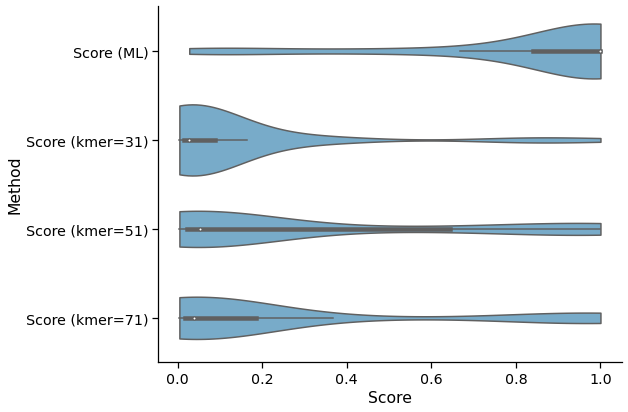

In [61]:
with sns.plotting_context("notebook", font_scale=1.3):
    g = sns.catplot(data=scores_long_df, kind="violin",
                    y="Method", x="Score", hue=None,
                    scale='area', inner='box',
                    ci=None, height=6, aspect=1.5,
                    cut=0,
                    color="#6baed6", edgecolor="black")
    plt.savefig('figures/tree-clustering-500.pdf')

## 4.7 Visualize clusters

In [62]:
from genomics_data_index.api.viewer.TreeStyler import TreeStyler, HighlightStyle
from genomics_data_index.api.query.SamplesQuery import SamplesQuery
from typing import List, Dict, Tuple

def highlight_lineages(ts: TreeStyler, query: SamplesQuery, lineage_labels: Dict[str, str]) -> TreeStyler:
    for lineage in lineage_labels:
        label = lineage_labels[lineage]
        ts = ts.highlight(query.isa(fr'^{lineage}', isa_column='lineage', kind='dataframe', regex=True),
                          legend_label=label)
    return ts

def annotate_lineages(ts: TreeStyler, query: SamplesQuery, lineages: List[str], colors: List[str] = None,
                     no_labels: bool = True) -> TreeStyler:
    if colors is None:
        colors = map(lambda x: 'black', lineages)
    for lineage, color in zip(lineages, colors):
        if no_labels:
            ts = ts.annotate(query.isa(fr'^{lineage}', isa_column='lineage', kind='dataframe', regex=True),
                 color_present=color)
        else:
            ts = ts.annotate(query.isa(fr'^{lineage}', isa_column='lineage', kind='dataframe', regex=True),
                 legend_label=lineage, color_present=color)

    return ts

def annotate_all_lineage_levels(ts: TreeStyler, query: SamplesQuery, scores_df: pd.DataFrame) -> TreeStyler:
    lineage_levels = scores_df['lineage level'].value_counts().index.tolist()
    lineage_levels.sort()
    for level in lineage_levels:
        lineages = scores_df.loc[scores_df['lineage level'] == level, 'lineage'].tolist()
        colors = scores_df.loc[scores_df['lineage level'] == level, 'color'].tolist()       
        ts = annotate_lineages(ts, query=q, lineages=lineages, colors=colors)
        
    return ts

def create_highlight_style(scores_df: pd.DataFrame, level: int) -> HighlightStyle:
    fg_colors = scores_df.loc[scores_df['lineage level'] == level, 'color'].tolist()
    bg_colors = fg_colors
    unknown_fg_color = 'lightgray'
    unknown_bg_color = 'lightgray'
    return HighlightStyle._create_highlights(fg_colors=fg_colors, bg_colors=bg_colors,
                                  unknown_bg_color=unknown_bg_color, unknown_fg_color=unknown_fg_color)

def create_lineage_data(scores_df: pd.DataFrame, 
                        score_column: str) -> Tuple[Dict[str,str], List[str], List[str]]:
    lineage_labels_dict = {}
    lineages_dict = {}
    colors_dict = {}
    for level in range(max_lineage_depth):
        lineages_dict[level] = scores_df.loc[scores_df['lineage level'] == level, 'lineage'].tolist()
        colors_dict[level] = scores_df.loc[scores_df['lineage level'] == level, 'color'].tolist()

        lineage_labels_dict[level] = {
            l: f'{l} (score={scores_df.loc[scores_df["lineage"] == l, score_column].values[0]:0.2f})' 
            for l in lineages_dict[level]}
    
    return lineage_labels_dict, lineages_dict, colors_dict

In [63]:
top_lineages_ml = scores_df.sort_values(['Score (ML)', 'Sample Count'], ascending=False).head(5)
top_lineages_ml

,lineage,Score (ML),Sample Count,Score (kmer=31),Score (kmer=51),Score (kmer=71),lineage level,color
3,D,1.0,36,0.073770,0.076433,0.074689,0,#f4cae4
10,D.2,1.0,36,0.073770,0.076433,0.074689,1,#2171b5
14,B.1.177,1.0,30,0.067416,0.080000,0.093168,2,#c4fba4
27,B.1.1.39,1.0,13,0.028953,0.027542,0.028322,3,#c5ebbe
4,A.1,1.0,12,0.024641,0.025000,0.024540,1,#eff3ff


### 4.7.1. Visualize ML scores

#### 4.7.1.1. On ML tree

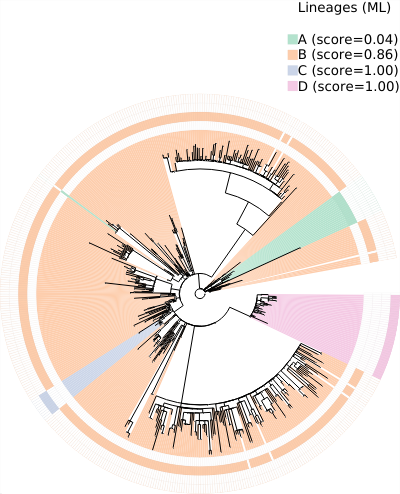

In [64]:
lineage_labels_dict, lineages_dict, colors_dict = create_lineage_data(scores_df=scores_df, score_column="Score (ML)")
display_level = 0

highlight_style = create_highlight_style(scores_df, level=display_level)

ts = q.tree_styler(mode='c', highlight_style=highlight_style,
                   legend_nsize=500, legend_fsize=500,
                   annotate_opacity_absent=1.0,
                   annotate_border_width=1,
                   annotate_box_width=450, annotate_box_height=100,
                   legend_type_label_present='', legend_type_label_unknown='',
                   legend_title='Lineages (ML)', annotate_show_box_label=False,
                   include_unknown=False, annotate_color_unknown='black',
                   show_leaf_names=False, annotate_guiding_lines=False,
                  )

ts = highlight_lineages(ts, query=q,
                        lineage_labels=lineage_labels_dict[display_level])
ts = annotate_lineages(ts, query=q,
                        lineages=lineages_dict[display_level], colors=colors_dict[display_level])
x = ts.render('figures/ml-tree-clusters.png', w=1600)
ts.render(w=400)

#### 4.7.1.2. On kmer=51 tree

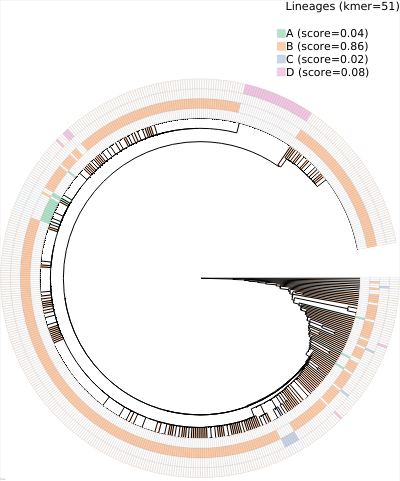

In [65]:
ts51 = q51.tree_styler(mode='c', highlight_style=highlight_style,
                   annotate_box_width=150, legend_nsize=125, legend_fsize=125,
                   annotate_opacity_absent=1.0,
                   legend_type_label_present='', legend_type_label_unknown='',
                   legend_title='Lineages (kmer=51)', annotate_show_box_label=False,
                   include_unknown=False, annotate_color_unknown='black',
                   show_leaf_names=False, annotate_guiding_lines=False)

lineage_labels_dict, lineages_dict, colors_dict = create_lineage_data(scores_df=scores_df, score_column="Score (kmer=51)")

ts51 = highlight_lineages(ts51, query=q51,
                        lineage_labels=lineage_labels_dict[display_level])
ts51 = annotate_lineages(ts51, query=q51,
                        lineages=lineages_dict[display_level], colors=colors_dict[display_level])
x = ts51.render('figures/kmer51-tree-clusters.png', w=1600)
ts51.render(w=400)